In [1]:
import utils
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import numpy as np
from scipy.interpolate import griddata
import time

numNODES=43712
numRLN=4
numFace=87985
np.random.seed(seed=0)
times=np.random.choice(range(9500),size=32,replace=False)
numSteps=1
numT=4
sz=[500]
stepSize=sz*numSteps

numVar=3

O_SHAPE=(numNODES,numT,numVar)
#P,vx,vy,reyn
RADJ_SHAPE=(numNODES,numRLN)
#x,y,faceLen
REDG_SHAPE=(numFace,2)
RA_SHAPE=(numFace,4)


varName=['Pressure','X-Velocity','Y-Velocity']

# model_name='model20200626-104248/20200626-104248.h5'
model_name='model20200622-232331/20200622-232331.h5'
path=['']
randtS=[times[0]*10]
# path=['lowreyn']
# randtS=[50]
# path=['hole']
# randtS=[3000]

#multiStep
numStep=25

In [2]:
with h5py.File('meshGraph2.h5','r') as graph:
    centCoord=np.asarray(graph['centCoord'])

In [3]:

new_model=tf.keras.models.load_model(model_name,compile=False)

In [4]:
def plotting_f(varName,initF,opF,predict,numStep):
    if numStep==1:
        numStep=''
   
    for flowVar,name in enumerate(varName):
        figs,axs=plt.subplots(nrows=3,figsize=(10,15),constrained_layout=True)
        print(name+' mse:' + str(tf.keras.losses.MSE(predict[:,flowVar],opF[:,flowVar])))
        print(name+' mae:' + str(tf.keras.losses.MAE(predict[:,flowVar],opF[:,flowVar])))
        pressInit=initF['O'][:,flowVar].numpy()
        pressAft=opF[:,flowVar]
        modelG=predict[:,flowVar]
        sources=['$t$','$t+'+str(numStep)+'\delta t$','$t+'+str(numStep)+'\delta t$']
        prefix=['','Ground Truth ','Model Prediction ']
        xcomp=centCoord[:,0]
        ycomp=centCoord[:,1]
        zcomp=[pressInit,pressAft,modelG]
        diff=(pressAft-modelG)
        delta=(pressAft-pressInit)
        change=(modelG-pressInit)
        p=0
#         axes=axs[flowVar]
#         custom_xlim = (-0.2, 0.5)
#         custom_ylim = (-0.2, 0.2)
#         plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
        for ax in axs:
            ax.title.set_text(prefix[p]+name+' at time='+sources[p])
            plot=ax.tricontour(xcomp,ycomp,zcomp[p],20,cmap='jet')
            p+=1
        figs.colorbar(plot,ax=axs)
        plt.savefig('Tests/single'+name+str(numStep)+'step.svg',format='svg')



    points=np.linspace(-0.25,2,1000)
    points=np.ma.masked_inside(points,-5e-2,5e-2)
    
#     points=np.ma.masked_inside(points,-0.1,0.1)
#     points=np.ma.masked_inside(points,0.5,0.7)
    # points=[points,np.zeros_like(points)]
    fig,ax=plt.subplots(nrows=3,figsize=(10,15),constrained_layout=True)
    init=tf.squeeze(initF['O'])-opF
    predE=tf.squeeze(initF['O'])-predict
    for x in range(3):
        gt=griddata(centCoord,init[:,x],(points,np.zeros_like(points)),method='linear')
        pD=griddata(centCoord,predE[:,x],(points,np.zeros_like(points)),method='linear')
        ax[x].plot(points,gt,label='Ground Truth')
        ax[x].plot(points,pD,'--',label='Model Prediction')
        ax[x].title.set_text('Change in '+varName[x])
        ax[x].legend()
        ax[x].axvline(-5e-2,color="black", linestyle="--")
        ax[x].axvline(5e-2,color="black", linestyle="--")
#         ax[x].axvline(-0.1,color="black", linestyle="--")
#         ax[x].axvline(0.1,color="black", linestyle="--")
        
#         ax[x].axvline(0.5,color="black", linestyle="--")
#         ax[x].axvline(0.7,color="black", linestyle="--")
    plt.savefig('Tests/changeplot'+str(numStep)+'.svg',format='svg')

    fig2,ax2=plt.subplots(nrows=3,figsize=(10,15),constrained_layout=True)
    for x in range(3):
        
        ax2[x].tricontour(xcomp,ycomp,predict[:,x],cmap='jet')
#         ax2[x].title.set_text(varName[x]+' at time='+sources[1])
#         ax2[x].legend()
#         ax2[x].axvline(-5e-2,color="black", linestyle="--")
#         ax2[x].axvline(5e-2,color="black", linestyle="--")

    # points=[points,np.zeros_like(points)]
    fig3,ax3=plt.subplots(nrows=3,figsize=(10,15),constrained_layout=True)
    init=opF
    predE=predict
    for x in range(3):
        gt=griddata(centCoord,init[:,x],(points,np.zeros_like(points)),method='linear')
        pD=griddata(centCoord,predE[:,x],(points,np.zeros_like(points)),method='linear')
        ax3[x].plot(points,gt,label='Ground Truth')
        ax3[x].plot(points,pD,'--',label='Model Prediction')
        ax3[x].title.set_text(varName[x]+' at time='+sources[1])
        ax3[x].legend()
        ax3[x].axvline(-5e-2,color="black", linestyle="--")
        ax3[x].axvline(5e-2,color="black", linestyle="--")
        
#         ax3[x].axvline(-0.1,color="black", linestyle="--")
#         ax3[x].axvline(0.1,color="black", linestyle="--")

#         ax3[x].axvline(0.5,color="black", linestyle="--")
#         ax3[x].axvline(0.7,color="black", linestyle="--")
    plt.savefig('Tests/singleslice'+str(numStep)+'.svg',format='svg')

In [5]:
inputData=tf.data.Dataset.from_generator(
            utils.dataGen,
output_types=({'O':tf.float32,
                           'Rr':tf.int32,
                           'Rs':tf.int32,
                            'Re':tf.int32,
                             'Ra1':tf.float32,
                          'global':tf.float32},
                        {'output':tf.float32}),
             output_shapes=({'O':O_SHAPE,
                           'Rr':RADJ_SHAPE,
                             'Rs':RADJ_SHAPE,
                            'Re':REDG_SHAPE,
                             'Ra1':RA_SHAPE,
                            'global':O_SHAPE},
                         {'output':(None,numVar)}),
            args=(path,randtS,sz,numT,True,)
        )



Pressure mse:tf.Tensor(0.00012749295, shape=(), dtype=float32)
Pressure mae:tf.Tensor(0.0049450216, shape=(), dtype=float32)
X-Velocity mse:tf.Tensor(0.00015300367, shape=(), dtype=float32)
X-Velocity mae:tf.Tensor(0.004694929, shape=(), dtype=float32)
Y-Velocity mse:tf.Tensor(0.00053367706, shape=(), dtype=float32)
Y-Velocity mae:tf.Tensor(0.006582806, shape=(), dtype=float32)


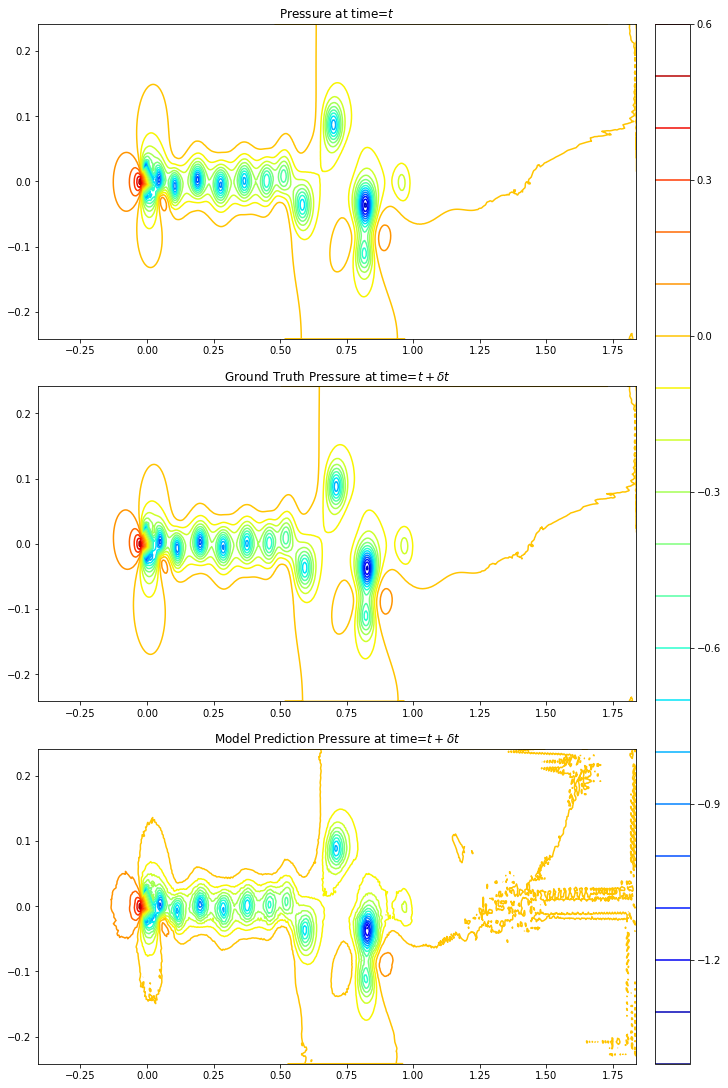

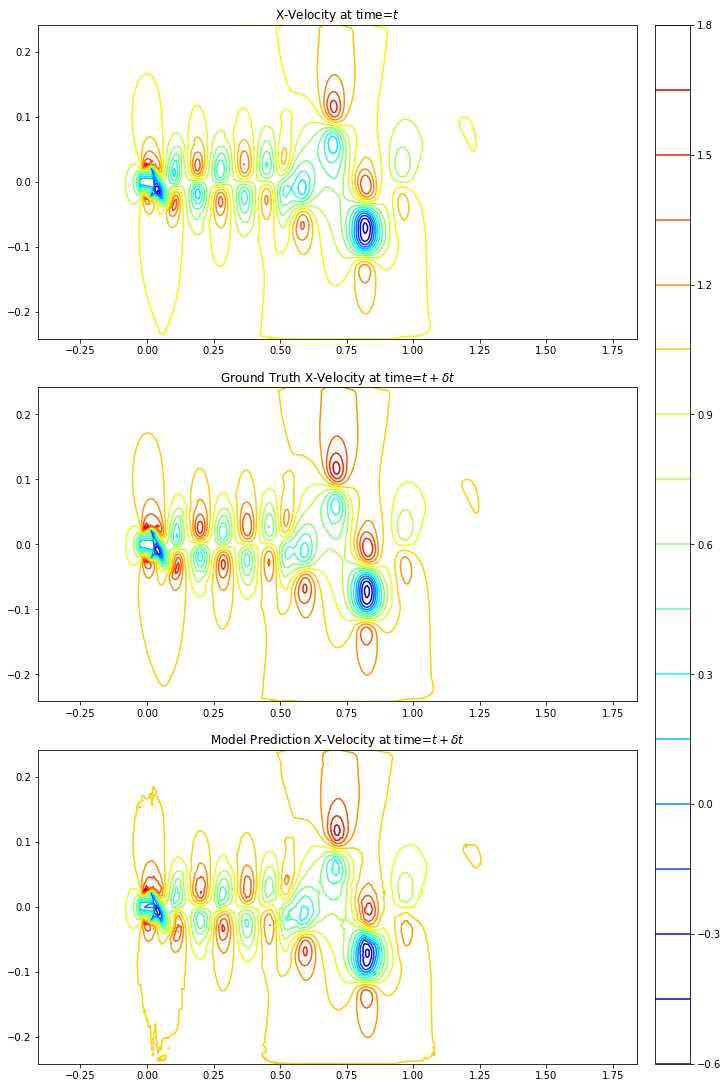

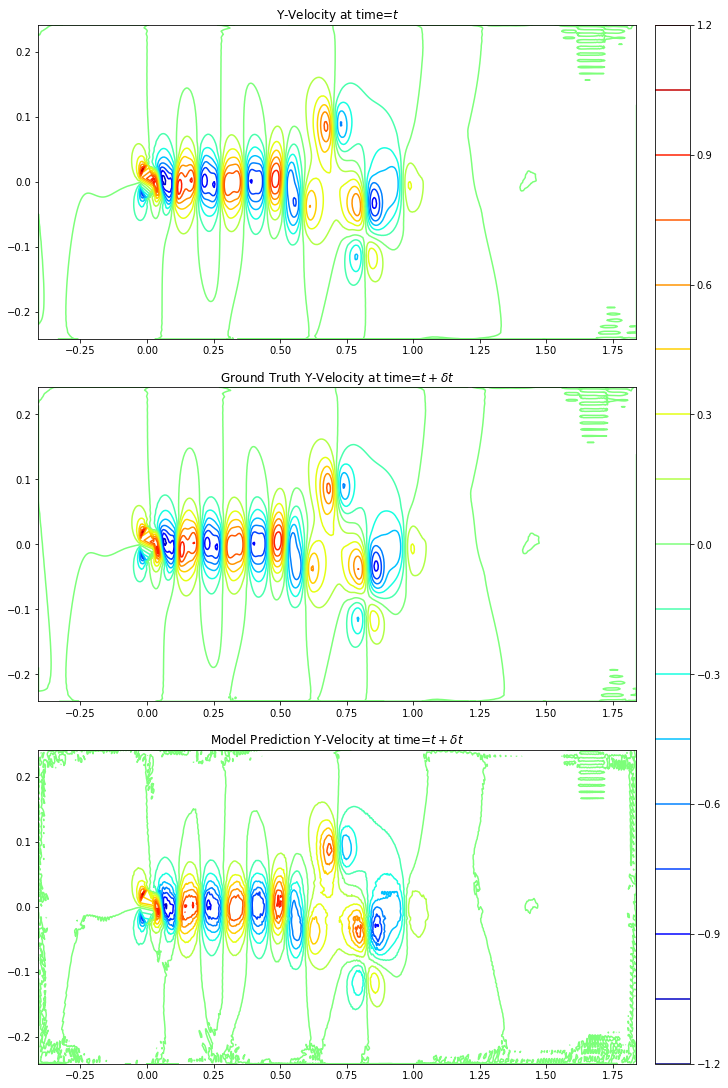

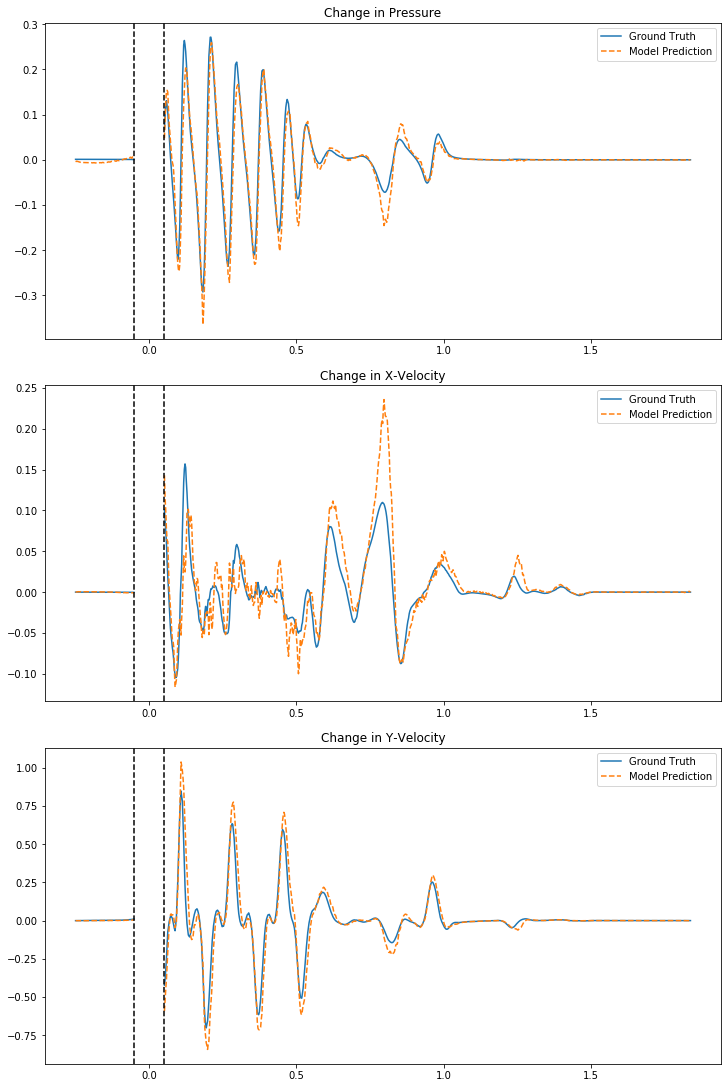

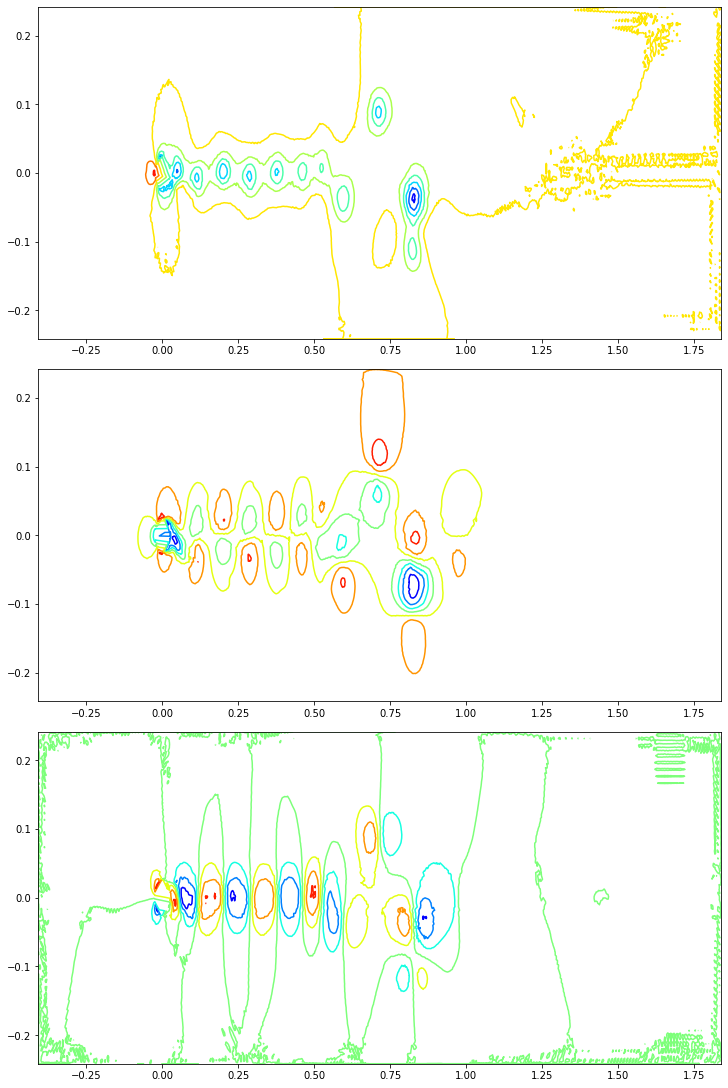

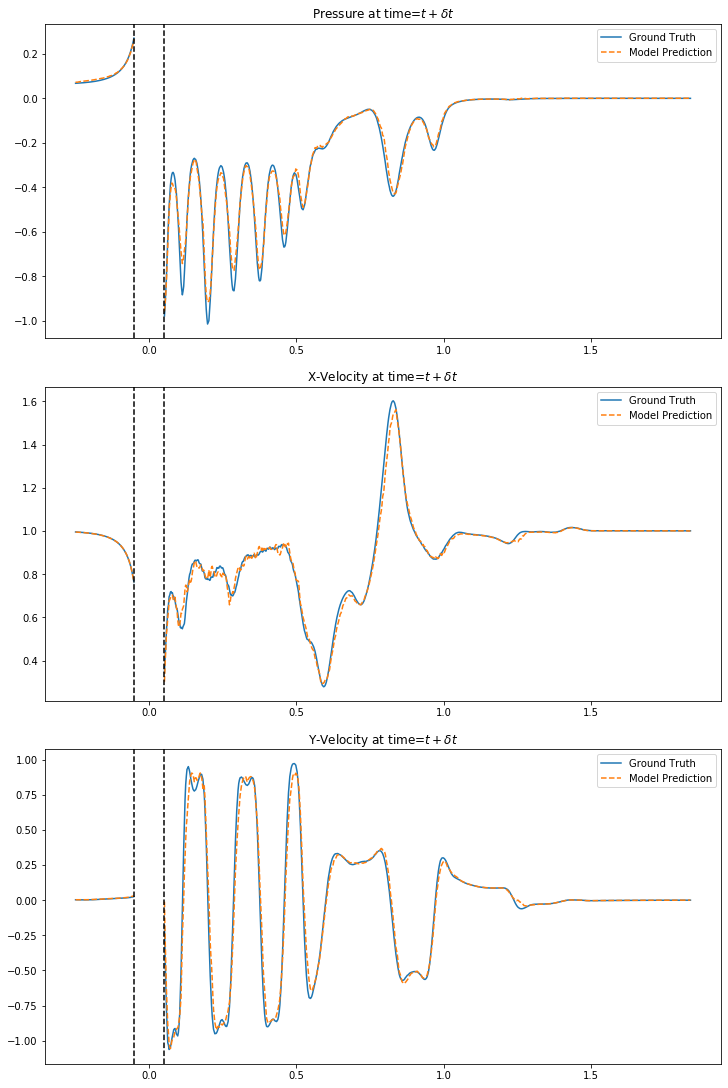

In [6]:
#singlestep
def reform(prev,delta):
    return (delta*sz[0]*1e-5)+prev

for x_Ri,x_Ro in inputData:
    predict=new_model([x_Ri['O'],x_Ri['Rr'],x_Ri['Rs'],x_Ri['Re'],x_Ri['Ra1'],x_Ri['global']])
#     predict=reform(x_Ri['O'][:,-1,:],predict)
#     x_Ro['output']=reform(x_Ri['O'][:,-1,:],x_Ro['output'])
    x_Ri['O']=x_Ri['O'][:,-1,:]

#     predict=predict+tf.transpose(tf.squeeze(x_Ri['O']))
    plotting_f(varName,x_Ri,x_Ro['output'],predict,1)
    


In [7]:


recurData=tf.data.Dataset.from_generator(
            utils.dataGen,
output_types=({'O':tf.float32,
                           'Rr':tf.int32,
                           'Rs':tf.int32,
                            'Re':tf.int32,
                             'Ra1':tf.float32,
                          'global':tf.float32},
                        {'output':tf.float32}),
             output_shapes=({'O':O_SHAPE,
                           'Rr':RADJ_SHAPE,
                             'Rs':RADJ_SHAPE,
                            'Re':REDG_SHAPE,
                             'Ra1':RA_SHAPE,
                            'global':O_SHAPE},
                         {'output':(None,numVar)}),
            args=(path,randtS,sz,numT,True,)
        )


def modelLoop(model,inputs,outputs,numSteps):
    predict=inputs['O']
    pred_O=[]
    for steps in range(numSteps):
        carryOver=predict[:,1:,:]
#         carryOver=predict[:,:-1,:]
#         predData={'O':predict,'Rr':inputs['Rr'],'Rs':inputs['Rs'],'Re':inputs['Re'],'Ra1':inputs['Ra1'],'global':inputs['global']}
        predData=[predict,inputs['Rr'],inputs['Rs'],inputs['Re'],inputs['Ra1'],inputs['global']]
        predict=model(predData)  
        pred_O.append(predict)
#         predict=reform(prev,predict)
        predict=tf.concat([carryOver,tf.expand_dims(predict,1)],axis=1)
        
    return pred_O

def interstage(fluid,stepNum):
    with h5py.File('E:/UROP/dat/karman2d'+fluid+'.dat.h5','r') as initF:
        xVel=np.asarray(initF['results']['1']['phase-1']['faces']['SV_U']['1'])
        yVel=np.asarray(initF['results']['1']['phase-1']['faces']['SV_V']['1'])
        uInf=((xVel**2+yVel**2)**0.5).max()
    return utils.dataExtract('E:/UROP/dat/karman2d'+fluid+'-1-'+str(stepNum)+'.dat.h5',uInf=uInf)



In [8]:
for recurIP,recurOp in recurData:
    predict1=modelLoop(new_model,recurIP,recurOp,numStep)
#         predict=predict+tf.transpose(tf.squeeze(predData['O']))
recurIP['O']=recurIP['O'][:,-1,:]
IP=tf.squeeze(recurIP['O'])
# recurOp['output']=reform(recurIP['O'],recurOp['output'])


In [9]:
errors=[]
error2=[]


for x in range(numStep):
    errors.append(tf.reduce_mean(tf.keras.losses.MSE(predict1[x],interstage(path[0],randtS[0]+(x+5)*sz[0]))))
    error2.append(tf.reduce_mean(tf.keras.losses.MSE(IP,interstage(path[0],randtS[0]+(x+5)*sz[0]))))

Pressure mse:tf.Tensor(0.046253175, shape=(), dtype=float32)
Pressure mae:tf.Tensor(0.09496656, shape=(), dtype=float32)
X-Velocity mse:tf.Tensor(0.08250477, shape=(), dtype=float32)
X-Velocity mae:tf.Tensor(0.1608927, shape=(), dtype=float32)
Y-Velocity mse:tf.Tensor(0.08838023, shape=(), dtype=float32)
Y-Velocity mae:tf.Tensor(0.13359094, shape=(), dtype=float32)


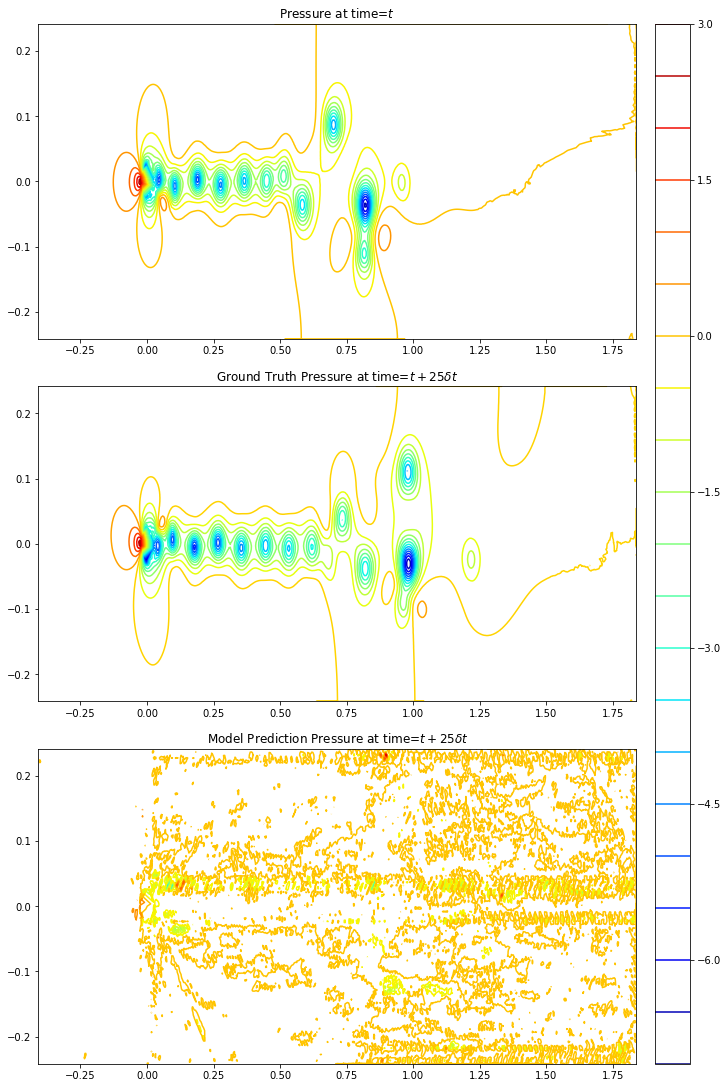

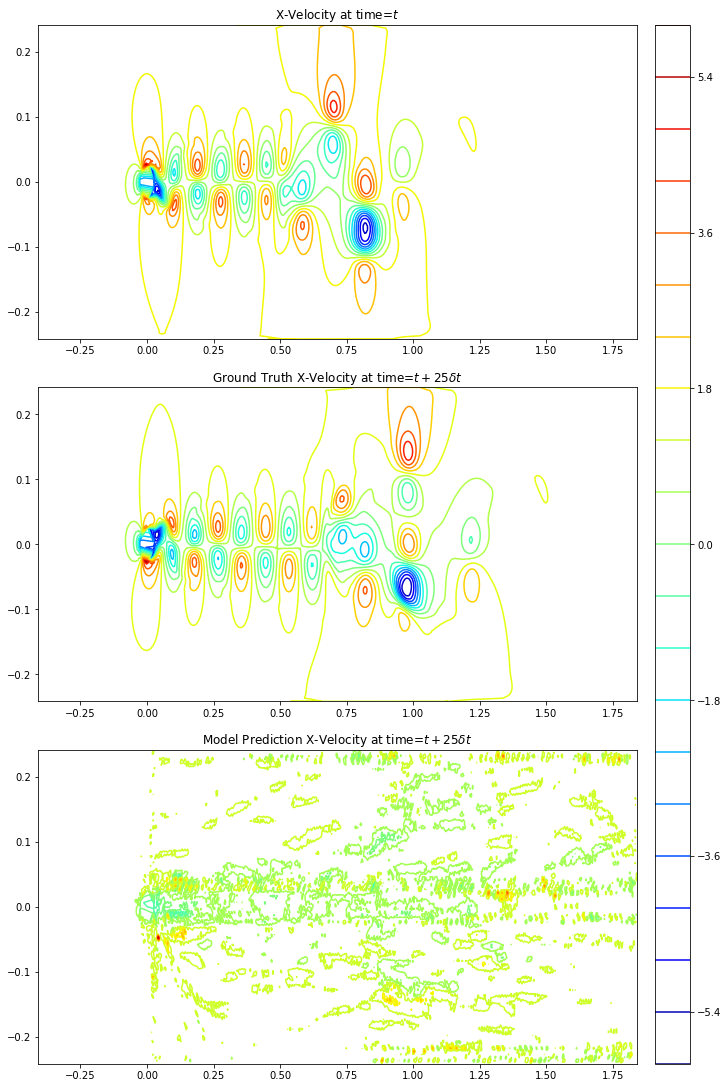

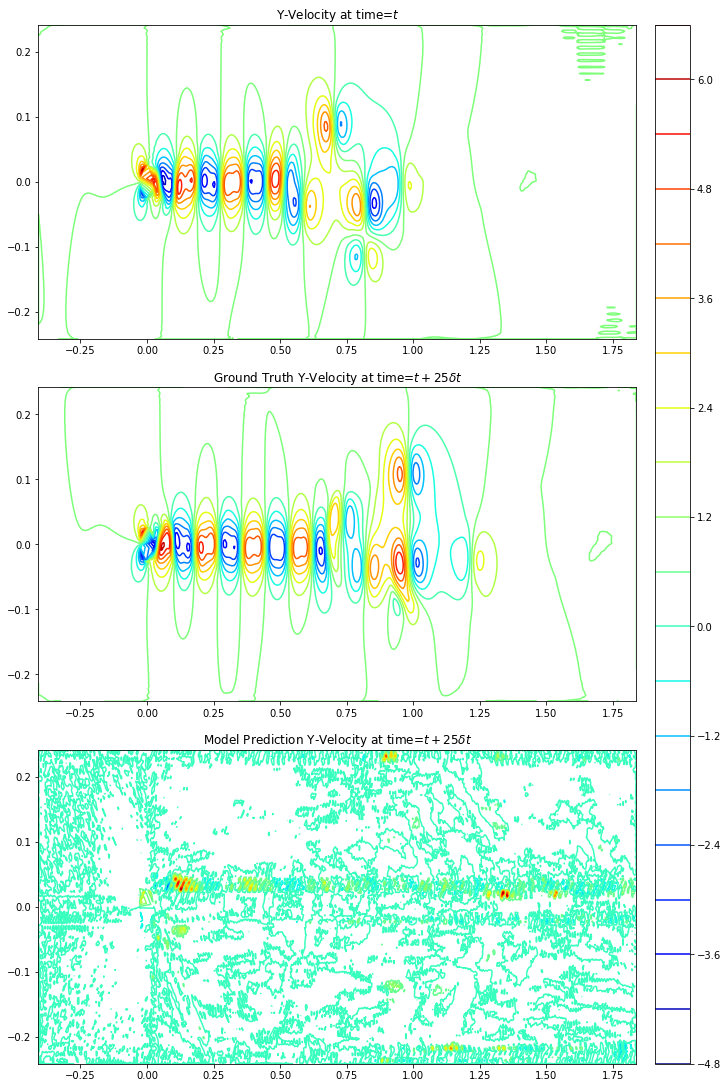

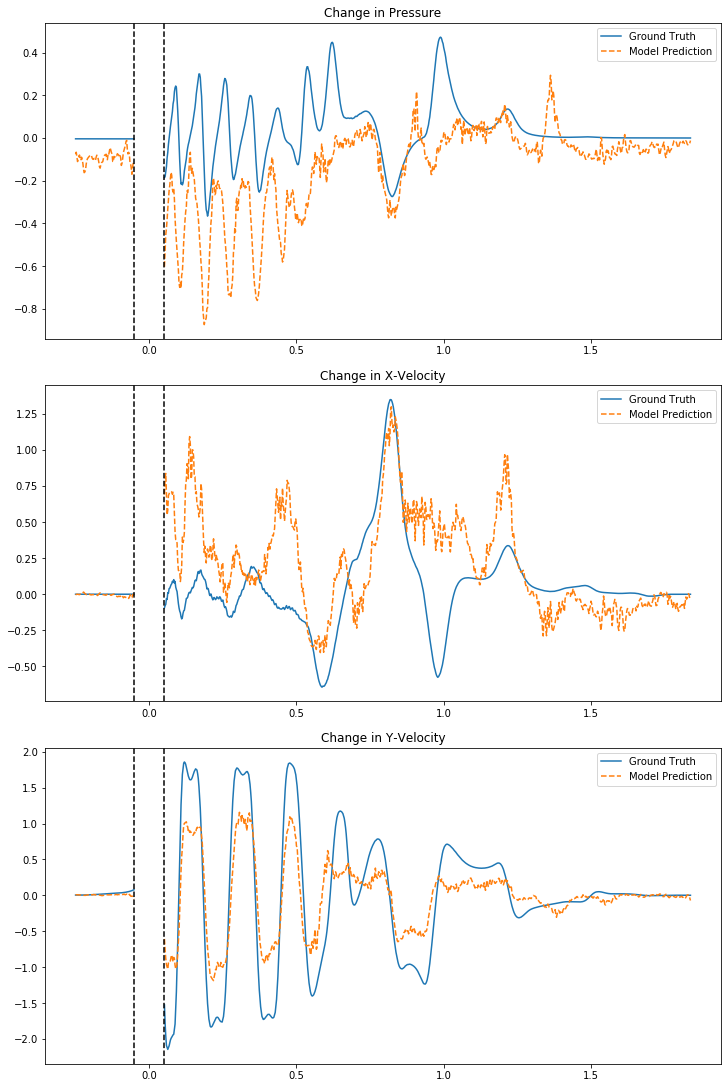

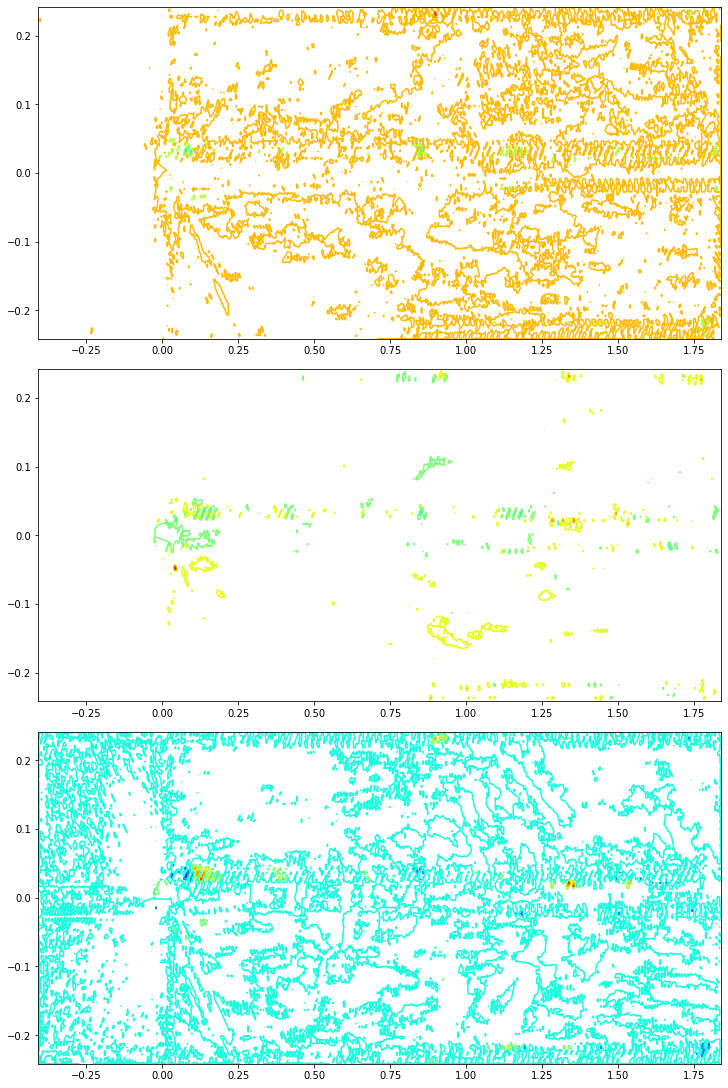

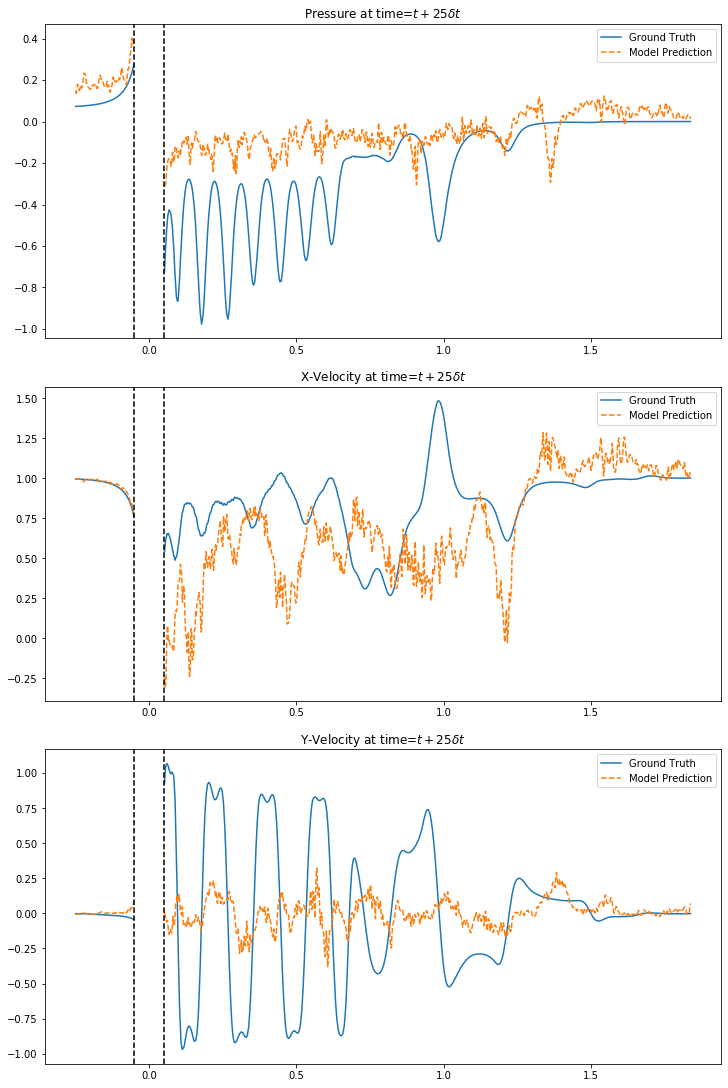

In [10]:
finaldat,_=interstage(path[0],randtS[0]+(x+5)*sz[0])
plotting_f(varName,recurIP,finaldat,predict1[-1],numStep)

In [11]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Ra1 (InputLayer)                [(None, 4)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te (None,)              0           Ra1[0][0]                        
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens (None, 3)            0           Ra1[0][0]                        
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8)            64          tf_op_layer_strided_slice_1[0][0]
____________________________________________________________________________________________

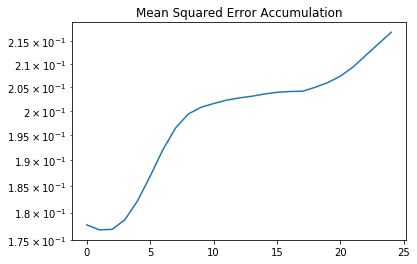

In [12]:
plt.semilogy(np.arange(len(errors)),errors)
plt.title('Mean Squared Error Accumulation')
plt.savefig('multiacc.svg',format='svg')

for x in range(3):
    print(tf.keras.losses.MSE(recurIP['O'][-1,x,:],recurOp['output'][:,x]))

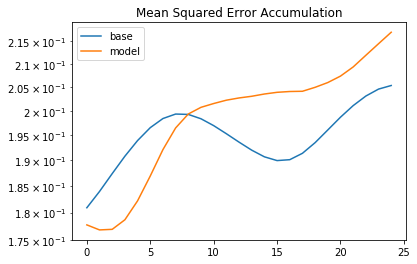

In [13]:

plt.semilogy(np.arange(len(error2)),error2,label='base')
plt.semilogy(np.arange(len(errors)),errors,label='model')
plt.legend()
plt.title('Mean Squared Error Accumulation')
plt.savefig('multiacc2.svg',format='svg')

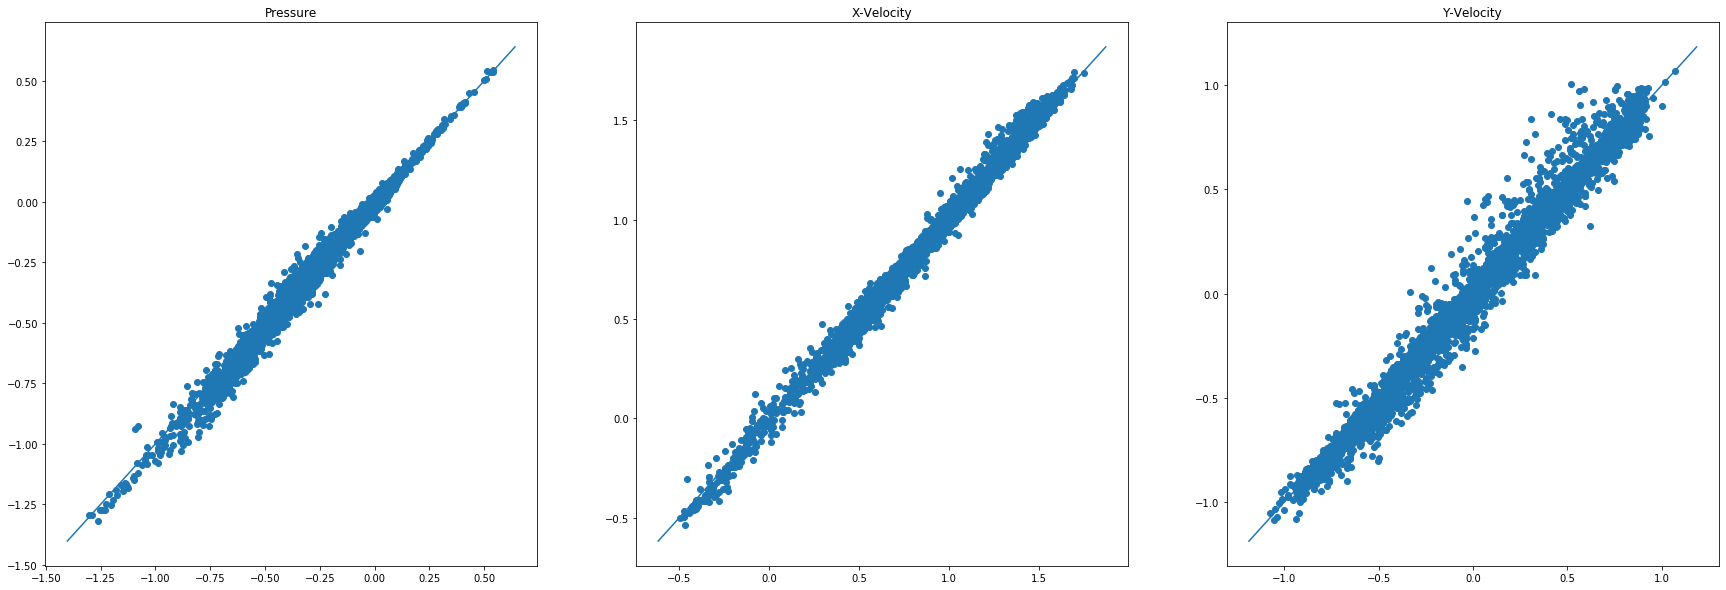

In [14]:
fig,ax=plt.subplots(ncols=3,figsize=(30,10))
a=x_Ro['output']
b=predict
for x,ax in enumerate(ax):
    ax.scatter(b[:,x],a[:,x])
    xlim=np.asarray(ax.get_xlim())
    ax.plot(xlim, xlim)
#     ax.plot(xlim, xlim*1.25,'--')
#     ax.plot(xlim, xlim*.75,'--')
    ax.title.set_text(varName[x])
plt.savefig('correl2.png')

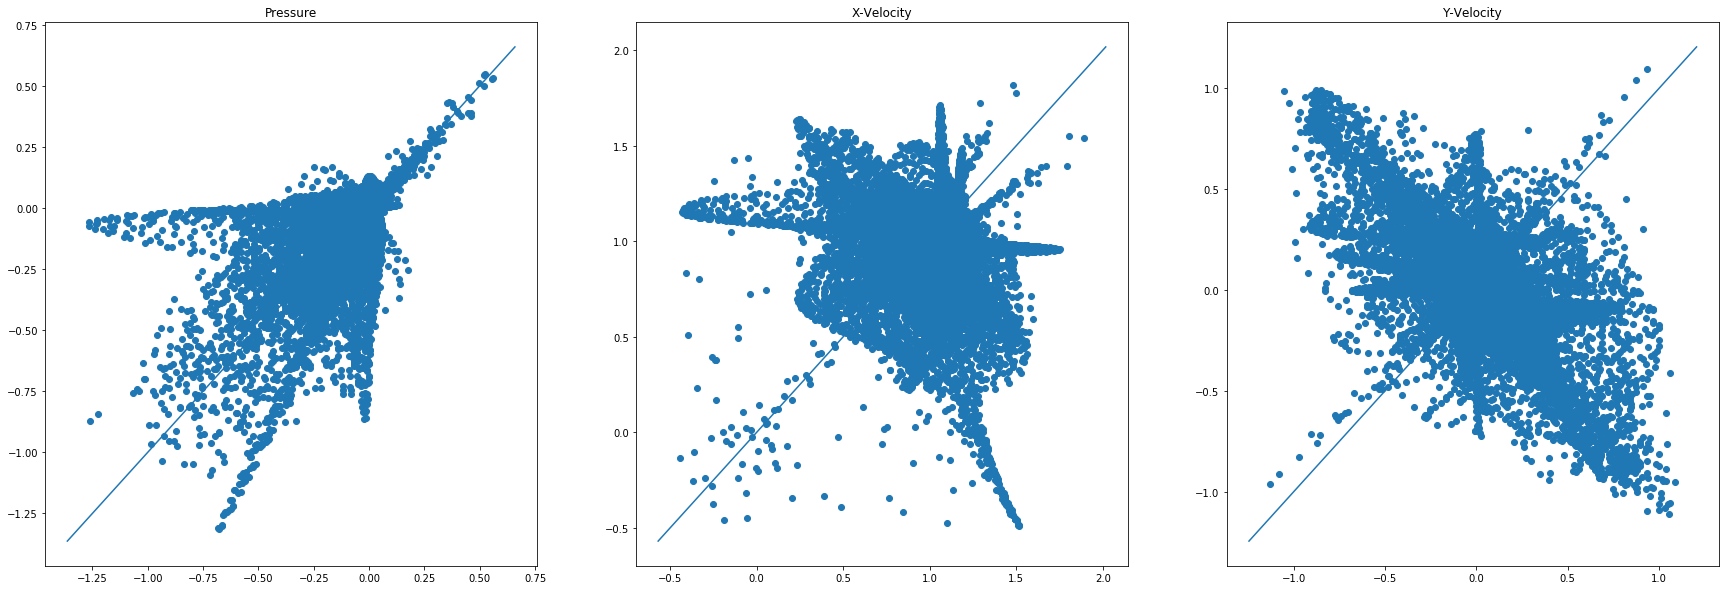

In [15]:
fig,ax=plt.subplots(ncols=3,figsize=(30,10))
a=tf.squeeze(x_Ri['O'])
# b=x_Ro['output']
b=finaldat
for x,ax in enumerate(ax):
    ax.scatter(b[:,x],a[:,x])
    ax.plot(ax.get_xlim(), ax.get_xlim())
    ax.title.set_text(varName[x])
plt.savefig('correl.png')

In [16]:
interstage(path[0],randtS[0]+(x+5)*sz[0])

(array([[ 2.1301894e-05,  1.0003685e+00, -1.7127160e-04],
        [ 3.6508725e-06,  9.9978304e-01, -1.2001826e-04],
        [ 8.9219429e-06,  1.0012360e+00, -2.2895838e-04],
        ...,
        [ 7.7690676e-02,  1.0000056e+00, -7.1152856e-05],
        [ 3.2831881e-02,  1.0316690e+00, -2.9402254e-05],
        [ 7.7891119e-02,  9.9998617e-01, -4.8575643e-05]], dtype=float32),
 array([[0.0000000e+00, 1.0048086e-06, 1.0048086e-06],
        [0.0000000e+00, 1.0048086e-06, 1.0048086e-06],
        [0.0000000e+00, 1.0048086e-06, 1.0048086e-06],
        ...,
        [0.0000000e+00, 1.0048086e-06, 1.0048086e-06],
        [0.0000000e+00, 1.0048086e-06, 1.0048086e-06],
        [0.0000000e+00, 1.0048086e-06, 1.0048086e-06]], dtype=float32))

In [17]:
z=0
for a,b in recurData:
    z+=1
    print(z)

1


In [18]:
sz

[500]

In [19]:
[5884, 7975,  903, 8996, 3498, 6157, 4695, 3568, 2505, 1134, 5424,
       5565, 7869, 6257, 8334, 3105, 5266, 6742, 8523,  349, 8405, 4336,
       4464,  332, 1004,  399,  209, 4377, 2700, 8337, 3335, 1469]

[5884,
 7975,
 903,
 8996,
 3498,
 6157,
 4695,
 3568,
 2505,
 1134,
 5424,
 5565,
 7869,
 6257,
 8334,
 3105,
 5266,
 6742,
 8523,
 349,
 8405,
 4336,
 4464,
 332,
 1004,
 399,
 209,
 4377,
 2700,
 8337,
 3335,
 1469]

In [20]:
import numpy as np
np.random.RandomState(0)
np.random.choice(range(9500),size=32,replace=False)

array([7896, 7732, 6946, 3629,  593, 5214, 3736, 5762, 9029, 3104, 3589,
       4676, 7658, 8567, 8881, 1846,  218, 9323, 3238, 5932, 9225, 9028,
       8632, 2060,  913, 3636, 5494, 5796,  413, 5529, 1648, 7777])

In [21]:
import numpy as np
np.random.seed(seed=0)
np.random.choice(range(9500),size=32,replace=False)

array([6550,  154, 6109, 5984, 5033,  888, 6164, 5292,  390, 2350, 7617,
       3667, 4678, 1995,  974, 1065, 1654, 4277, 5842, 8149, 7748, 3689,
       2499, 5417, 4476, 1051, 4406, 5068, 2631,  234,  247, 7959])

In [22]:
import os
os.listdir("E:/UROP/dat/karman2d-1-5884")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:/UROP/dat/karman2d-1-5884'